In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
import nltk

folder_path = "/content/drive/My Drive/521-q2-q3-q4-hw5"
if os.path.exists(folder_path):
    print(f"Folder '{folder_path}' exists.")
    !ls -l "{folder_path}"
else:
    print(f"Folder '{folder_path}' does not exist.")
    raise FileNotFoundError("Required folder not found.")

vqa_dir = "/content/vqa_dataset"
os.makedirs(vqa_dir, exist_ok=True)

def unzip_file(zip_file, destination):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination)
        print(f"Extracted: {zip_file} to {destination}")

train_annotations_zip = os.path.join(folder_path, "Annotations_Binary_Train2017_abstract_v002.zip")
train_questions_zip = os.path.join(folder_path, "Questions_Binary_Train2017_abstract_v002.zip")
train_images_zip = os.path.join(folder_path, "scene_img_abstract_v002_binary_train2017.zip")
val_annotations_zip = os.path.join(folder_path, "Annotations_Binary_Val2017_abstract_v002.zip")
val_questions_zip = os.path.join(folder_path, "Questions_Binary_Val2017_abstract_v002.zip")
val_images_zip = os.path.join(folder_path, "scene_img_abstract_v002_binary_val2017.zip")

print("Unzipping training and validation files...")
unzip_file(train_annotations_zip, vqa_dir)
unzip_file(train_questions_zip, vqa_dir)
unzip_file(train_images_zip, os.path.join(vqa_dir, "scene_img_abstract_v002_train2017"))
unzip_file(val_annotations_zip, vqa_dir)
unzip_file(val_questions_zip, vqa_dir)
unzip_file(val_images_zip, os.path.join(vqa_dir, "scene_img_abstract_v002_val2017"))

import json

def load_json_file(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

train_questions_file = os.path.join(vqa_dir, "OpenEnded_abstract_v002_train2017_questions.json")
train_annotations_file = os.path.join(vqa_dir, "abstract_v002_train2017_annotations.json")
val_questions_file = os.path.join(vqa_dir, "OpenEnded_abstract_v002_val2017_questions.json")
val_annotations_file = os.path.join(vqa_dir, "abstract_v002_val2017_annotations.json")

train_questions_data = load_json_file(train_questions_file)
train_annotations_data = load_json_file(train_annotations_file)
val_questions_data = load_json_file(val_questions_file)
val_annotations_data = load_json_file(val_annotations_file)

print(f"Loaded {len(train_questions_data['questions'])} training questions and {len(train_annotations_data['annotations'])} annotations.")
print(f"Loaded {len(val_questions_data['questions'])} validation questions and {len(val_annotations_data['annotations'])} annotations.")

nltk.download('punkt_tab')

def build_vocab(questions):
    vocab = {'<unk>': 0, '<pad>': 1}
    idx = 2
    words = set()
    for q in questions:
        words.update(nltk.word_tokenize(q['question'].lower()))
    for word in sorted(words):
        vocab[word] = idx
        idx += 1
    return vocab

vocab = build_vocab(train_questions_data['questions'])
print(f"Vocabulary size: {len(vocab)}")

Mounted at /content/drive
Folder '/content/drive/My Drive/521-q2-q3-q4-hw5' exists.
total 4426479
-rw------- 1 root root     427796 Dec 10 19:49 Annotations_Binary_Train2017_abstract_v002.zip
-rw------- 1 root root     252548 Dec 10 21:03 Annotations_Binary_Val2017_abstract_v002.zip
-rw------- 1 root root      23091 Dec  6 06:11 cs521-hw5-q1.ipynb
-rw------- 1 root root      58990 Dec 11 00:33 cs521-hw5-q2.ipynb
-rw------- 1 root root     313868 Dec 10 19:49 Questions_Binary_Train2017_abstract_v002.zip
-rw------- 1 root root     160583 Dec 10 21:03 Questions_Binary_Val2017_abstract_v002.zip
-rw------- 1 root root 2984805760 Dec 10 19:55 scene_img_abstract_v002_binary_train2017.zip
-rw------- 1 root root 1546669047 Dec 10 21:06 scene_img_abstract_v002_binary_val2017.zip
Unzipping training and validation files...
Extracted: /content/drive/My Drive/521-q2-q3-q4-hw5/Annotations_Binary_Train2017_abstract_v002.zip to /content/vqa_dataset
Extracted: /content/drive/My Drive/521-q2-q3-q4-hw5/Qu

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Vocabulary size: 2752


In [ ]:
!ls -l /content/vqa_dataset/scene_img_abstract_v002_train2017 | head -n 5
!ls -l /content/vqa_dataset/scene_img_abstract_v002_val2017 | head -n 5

total 2956552
-rw-r--r-- 1 root root 208269 Dec 11 19:42 abstract_v002_train2015_000000000004.png
-rw-r--r-- 1 root root 170164 Dec 11 19:42 abstract_v002_train2015_000000000005.png
-rw-r--r-- 1 root root 159514 Dec 11 19:42 abstract_v002_train2015_000000000006.png
-rw-r--r-- 1 root root 204917 Dec 11 19:41 abstract_v002_train2015_000000000008.png
total 1532312
-rw-r--r-- 1 root root 161594 Dec 11 19:42 abstract_v002_val2015_000000020001.png
-rw-r--r-- 1 root root 144818 Dec 11 19:42 abstract_v002_val2015_000000020002.png
-rw-r--r-- 1 root root 122450 Dec 11 19:42 abstract_v002_val2015_000000020004.png
-rw-r--r-- 1 root root 109444 Dec 11 19:42 abstract_v002_val2015_000000020005.png


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence

class VQADataset(Dataset):
    def __init__(self, img_dir, questions, annotations, vocab, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.vocab = vocab
        self.data = [
            (q['image_id'], q['question'], a['multiple_choice_answer'])
            for q, a in zip(questions, annotations)
            if a['multiple_choice_answer'] in ['yes', 'no']
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id, question, answer = self.data[idx]
        img_filename = f"abstract_v002_train2015_{int(img_id):012d}.png" if 'train' in self.img_dir else f"abstract_v002_val2015_{int(img_id):012d}.png"
        img_path = os.path.join(self.img_dir, img_filename)
        try:
            img = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            img = Image.new('RGB', (224, 224), (0, 0, 0))  # dummy img if fail
        if self.transform:
            img = self.transform(img)
        tokens = nltk.word_tokenize(question.lower())
        question_vec = [self.vocab.get(word, self.vocab['<unk>']) for word in tokens]
        label = 1 if answer == 'yes' else 0
        return img, torch.tensor(question_vec, dtype=torch.long), torch.tensor(label, dtype=torch.long)

class VQAModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(VQAModel, self).__init__()

        self.cnn = models.vgg16(pretrained=True)
        self.cnn.classifier = nn.Sequential()
        for param in self.cnn.parameters():
            param.requires_grad = False  # freeze CNN params to speed up training

        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=1)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(25088 + hidden_dim, 1024)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(1024, 2)  # binary classification

    def forward(self, img, q, lengths):
        img_feat = self.cnn(img)
        img_feat = img_feat.view(img_feat.size(0), -1)
        q_embed = self.embed(q)
        packed = nn.utils.rnn.pack_padded_sequence(q_embed, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (h, c) = self.lstm(packed)
        q_feat = h[-1]  # last hidden state from LSTM

        combined = torch.cat([img_feat, q_feat], dim=1)
        combined = self.fc1(combined)
        combined = self.relu(combined)
        combined = self.dropout(combined)
        output = self.classifier(combined)

        return output

def collate_fn(batch):
    imgs, qs, labels = zip(*batch)
    imgs = torch.stack(imgs)
    lengths = [len(q) for q in qs]
    padded_qs = pad_sequence(qs, batch_first=True, padding_value=1)
    labels = torch.stack(labels)
    return imgs, padded_qs, labels, lengths

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_loader = DataLoader(VQADataset(
    "/content/vqa_dataset/scene_img_abstract_v002_train2017",
    train_questions_data['questions'],
    train_annotations_data['annotations'],
    vocab,
    transform
), batch_size=32, shuffle=True, collate_fn=collate_fn)

val_loader = DataLoader(VQADataset(
    "/content/vqa_dataset/scene_img_abstract_v002_val2017",
    val_questions_data['questions'],
    val_annotations_data['annotations'],
    vocab,
    transform
), batch_size=32, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQAModel(len(vocab), embed_dim=300, hidden_dim=512, num_layers=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import time
import torch

num_epochs = 10
start_time = time.time()

examples_correct = []
examples_incorrect = []

best_val_accuracy = 0.0
best_epoch = 0
checkpoint_frequency = 5

print("Starting training and validation process...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, qs, labels, lengths in train_loader:
        imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, qs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}")

    model.eval()
    correct, total = 0, 0
    examples_correct.clear()
    examples_incorrect.clear()
    with torch.no_grad():
        for imgs, qs, labels, lengths in val_loader:
            imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)
            outputs = model(imgs, qs, lengths)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for i in range(len(labels)):
                if preds[i] == labels[i] and len(examples_correct) < 2:
                    examples_correct.append((qs[i].cpu().numpy(), preds[i].item(), labels[i].item()))
                elif preds[i] != labels[i] and len(examples_incorrect) < 2:
                    examples_incorrect.append((qs[i].cpu().numpy(), preds[i].item(), labels[i].item()))
    val_accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        torch.save({
            'epoch': best_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'val_accuracy': val_accuracy,
            'vocab': vocab
        }, '/content/best_vqa_model.pth')
        print(f"**Saved Best Model at Epoch {best_epoch} with Validation Accuracy: {best_val_accuracy:.4f}**\n")
    else:
        print(f"No improvement in validation accuracy for Epoch {epoch+1}.\n")

    if (epoch + 1) % checkpoint_frequency == 0:
        checkpoint_path = f'/content/checkpoint_epoch_{epoch+1}.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'val_accuracy': val_accuracy,
            'vocab': vocab
        }, checkpoint_path)
        print(f"**Saved Checkpoint at Epoch {epoch+1}**\n")

total_training_time = time.time() - start_time
print(f"Training completed in {total_training_time:.2f} seconds.")

Starting training and validation process...
Epoch [1/10], Training Loss: 0.6961
Epoch [1/10], Validation Accuracy: 0.5099
**Saved Best Model at Epoch 1 with Validation Accuracy: 0.5099**

Epoch [2/10], Training Loss: 0.6957
Epoch [2/10], Validation Accuracy: 0.5100
**Saved Best Model at Epoch 2 with Validation Accuracy: 0.5100**

Epoch [3/10], Training Loss: 0.6944
Epoch [3/10], Validation Accuracy: 0.5087
No improvement in validation accuracy for Epoch 3.

Epoch [4/10], Training Loss: 0.6938
Epoch [4/10], Validation Accuracy: 0.5105
**Saved Best Model at Epoch 4 with Validation Accuracy: 0.5105**

Epoch [5/10], Training Loss: 0.6933
Epoch [5/10], Validation Accuracy: 0.5127
**Saved Best Model at Epoch 5 with Validation Accuracy: 0.5127**

**Saved Checkpoint at Epoch 5**

Epoch [6/10], Training Loss: 0.6924
Epoch [6/10], Validation Accuracy: 0.5179
**Saved Best Model at Epoch 6 with Validation Accuracy: 0.5179**

Epoch [7/10], Training Loss: 0.6908
Epoch [7/10], Validation Accuracy: 0.

In [ ]:
!pip install nltk scikit-image
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from glob import glob
from skimage.segmentation import slic
from sklearn.linear_model import Ridge
import random
from copy import deepcopy
import os

In [ ]:
def compute_vanilla_grad(input_tensor, target_class, model, device):
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    model.zero_grad()
    output = model(input_tensor)
    loss = output[0, target_class]
    loss.backward()
    grad = input_tensor.grad.data.abs().mean(dim=1).squeeze().cpu().numpy()
    return grad

def smooth_grad(input_tensor, target_class, model, device, stdev_spread=0.15, n_samples=50, magnitude=True):
    stdev = (stdev_spread * (input_tensor.max() - input_tensor.min())).item()
    total_gradients = np.zeros(input_tensor.shape)

    for _ in range(n_samples):
        noise = torch.normal(mean=0, std=stdev, size=input_tensor.shape, device=device)
        noisy_input = input_tensor + noise
        gradient = compute_vanilla_grad(noisy_input, target_class, model, device)

        if magnitude:
            total_gradients += (gradient * gradient)
        else:
            total_gradients += gradient

    avg_gradients = total_gradients / n_samples
    avg_gradients = (avg_gradients - avg_gradients.min()) / (avg_gradients.max() - avg_gradients.min())
    return avg_gradients

def segment_image(image_tensor, n_segments=50):
    if isinstance(image_tensor, torch.Tensor):
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    elif isinstance(image_tensor, np.ndarray):
        image_np = image_tensor
    else:
        raise ValueError("Input must be a torch.Tensor or numpy.ndarray")

    segments = slic(image_np, n_segments=n_segments, compactness=10, sigma=1)
    return segments  # (H, W)

def generate_perturbations(n_superpixels, n_samples=1000):
    perturbations = np.random.randint(0, 2, (n_samples, n_superpixels))
    perturbations[0, :] = 1
    return perturbations

def apply_perturbation(input_image, segments, mask):
    perturbed_image = input_image.clone()
    segments_tensor = torch.tensor(segments, device=perturbed_image.device)
    for i in range(len(mask)):
        if mask[i] == 0:
            region_mask = (segments_tensor == i)
            region_mask = region_mask.unsqueeze(0).expand_as(perturbed_image)
            perturbed_image[region_mask] = perturbed_image[region_mask].mean()
    return perturbed_image

def get_predictions(input_tensor, perturbations, segments, predicted_idx, model, device):
    predictions = []
    for mask in perturbations:
        perturbed_image = apply_perturbation(input_tensor, segments, mask)
        perturbed_image = perturbed_image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(perturbed_image)
            prob = torch.softmax(output, dim=1)[0, predicted_idx].item()
        predictions.append(prob)
    return np.array(predictions)

def compute_weights(perturbations, kernel_width):
    distances = np.sum(perturbations == 0, axis=1)
    weights = np.exp(-(distances**2) / kernel_width**2)
    return weights

def custom_lime_explanation(input_tensor, model, predicted_idx, device, num_samples=1000, n_segments=50, kernel_width=0.25):
    image_np = input_tensor.detach().permute(1, 2, 0).cpu().numpy()
    segments = segment_image(image_np, n_segments)
    n_superpixels = np.unique(segments).shape[0]

    perturbations = generate_perturbations(n_superpixels, num_samples)
    predictions = get_predictions(input_tensor, perturbations, segments, predicted_idx, model, device)

    weights = compute_weights(perturbations, kernel_width * n_superpixels)

    clf = Ridge(alpha=1)
    clf.fit(perturbations, predictions, sample_weight=weights)

    importance_map = np.zeros_like(segments, dtype=float)
    for i in range(n_superpixels):
        importance_map[segments == i] = clf.coef_[i]

    return importance_map

def aggregate_lime_over_superpixels(lime_map, segments, n_superpixels):
    superpixel_lime = []
    for i in range(n_superpixels):
        mask = (segments == i)
        if mask.sum() == 0:
            superpixel_lime.append(0.0)
        else:
            mean_lime_value = lime_map[mask].mean()
            superpixel_lime.append(mean_lime_value)
    return np.array(superpixel_lime)

def decode_question(question_vec, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    return ' '.join([inv_vocab.get(idx, '<unk>') for idx in question_vec])

def show_image(image, title=''):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

def show_grayscale_image(image, title=''):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

def show_heatmap_image(image, title=''):
    plt.imshow(image, cmap='inferno')
    plt.title(title)
    plt.axis('off')

from scipy.stats import rankdata

def get_ranks(importances):
    return rankdata(-importances)

def kendall_tau(x, y):
    n = len(x)
    num_concordant = 0
    num_discordant = 0
    for i in range(n):
        for j in range(i+1, n):
            concordant = (x[i] - x[j]) * (y[i] - y[j]) > 0
            discordant = (x[i] - x[j]) * (y[i] - y[j]) < 0
            num_concordant += concordant
            num_discordant += discordant
    tau = (num_concordant - num_discordant) / (0.5 * n * (n - 1))
    return tau

def spearman_rank_correlation(x, y):
    n = len(x)
    diff = x - y
    diff_sq = diff**2
    rho = 1 - (6 * np.sum(diff_sq)) / (n * (n**2 - 1))
    return rho

In [ ]:
import torch.nn as nn
import torchvision.models as models

class VQAExplainModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=1):
        super(VQAExplainModel, self).__init__()
        self.cnn = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.cnn.classifier = nn.Identity()
        for param in self.cnn.parameters():
            param.requires_grad = False

        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=1)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)

        combined_dim = hidden_dim + 25088
        self.fc1 = nn.Linear(combined_dim, 1024)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, img, q, lengths):
        img_features = self.cnn(img)
        img_features = img_features.view(img_features.size(0), -1)
        q_embed = self.embed(q)
        packed = nn.utils.rnn.pack_padded_sequence(q_embed, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (h, _) = self.lstm(packed)
        q_features = h[-1]
        combined = torch.cat([img_features, q_features], dim=1)
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.classifier(x)
        return out


In [ ]:
best_model_path = '/content/best_vqa_model.pth'
checkpoint = torch.load(best_model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
epoch = checkpoint['epoch']
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']
loss = checkpoint['loss']
val_accuracy = checkpoint['val_accuracy']
vocab = checkpoint['vocab']
vocab_size = len(vocab)
embed_size = 300
num_classes = 2
model = VQAExplainModel(vocab_size, embed_size, 512, num_classes)
model.load_state_dict(model_state_dict)
model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
print(f"Loaded model from Epoch {epoch} with Validation Accuracy: {val_accuracy:.4f}")

<ipython-input-26-71cf1fdfb41d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=torch.device('cuda' if torch.cuda.is_a

Loaded model from Epoch 10 with Validation Accuracy: 0.5265


In [ ]:
from torch.utils.data import Dataset, DataLoader

class VQAExplainDataset(Dataset):
    def __init__(self, img_dir, questions, annotations, vocab, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.vocab = vocab
        self.data = [
            (q['image_id'], q['question'], a['multiple_choice_answer'])
            for q, a in zip(questions, annotations)
            if a['multiple_choice_answer'] in ['yes', 'no']
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_id, question, answer = self.data[idx]
        if 'train' in self.img_dir:
            img_filename = f"abstract_v002_train2015_{int(image_id):012d}.png"
        else:
            img_filename = f"abstract_v002_val2015_{int(image_id):012d}.png"
        img_path = os.path.join(self.img_dir, img_filename)
        try:
            img = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            img = Image.new('RGB', (224, 224), (0, 0, 0))
        if self.transform:
            img = self.transform(img)
        tokens = nltk.word_tokenize(question.lower())
        question_vec = [self.vocab.get(word, self.vocab['<unk>']) for word in tokens]
        label = 1 if answer == 'yes' else 0
        return img, torch.tensor(question_vec, dtype=torch.long), torch.tensor(label, dtype=torch.long), img_path

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    """
    Custom collate function to handle variable-length questions.
    """
    imgs, qs, labels, img_paths = zip(*batch)
    imgs = torch.stack(imgs)
    labels = torch.tensor(labels, dtype=torch.long)
    qs_lengths = [len(q) for q in qs]
    qs_padded = pad_sequence(qs, batch_first=True, padding_value=1)
    return imgs, qs_padded, labels, qs_lengths, img_paths

In [ ]:
val_questions_path = '/content/vqa_dataset/OpenEnded_abstract_v002_val2017_questions.json'
val_annotations_path = '/content/vqa_dataset/abstract_v002_val2017_annotations.json'

with open(val_questions_path, 'r') as f:
    val_questions_data = json.load(f)

with open(val_annotations_path, 'r') as f:
    val_annotations_data = json.load(f)

val_img_dir = '/content/vqa_dataset/scene_img_abstract_v002_val2017/'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

val_dataset = VQAExplainDataset(
    img_dir=val_img_dir,
    questions=val_questions_data['questions'],
    annotations=val_annotations_data['annotations'],
    vocab=vocab,
    transform=preprocess
)

val_loader_exp = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=custom_collate_fn
)

In [ ]:
def decode_question(question_vec, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    return ' '.join([inv_vocab[word] for word in question_vec if word in inv_vocab])

def custom_lime_explanation(img_tensor, question_tensor, lengths, model, target_class, device, num_samples=500, n_segments=50, kernel_width=0.25):
    image_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    segments = segment_image(img_tensor, n_segments)
    n_superpixels = np.unique(segments).shape[0]
    perturbations = generate_perturbations(n_superpixels, num_samples)
    predictions = get_predictions(img_tensor, question_tensor, lengths, perturbations, segments, target_class, model, device)
    weights = compute_weights(perturbations, kernel_width * n_superpixels)
    clf = Ridge(alpha=1)
    clf.fit(perturbations, predictions, sample_weight=weights)
    importance_map = np.zeros_like(segments, dtype=float)
    for i in range(n_superpixels):
        importance_map[segments == i] = clf.coef_[i]
    return importance_map

def get_predictions(img_tensor, question_tensor, lengths, perturbations, segments, target_class, model, device):
    predictions = []
    for mask in perturbations:
        perturbed_img = apply_perturbation(img_tensor, segments, mask)
        perturbed_img = perturbed_img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(perturbed_img, question_tensor, lengths)
        prob = torch.softmax(output, dim=1)[0, target_class].item()
        predictions.append(prob)
    return np.array(predictions)

In [ ]:
selected_examples = []
max_correct = 2
max_incorrect = 2

model.eval()

with torch.no_grad():
    for imgs, qs_padded, labels, qs_lengths, img_paths in val_loader_exp:
        imgs = imgs.to(device)
        qs_padded = qs_padded.to(device)
        labels = labels.to(device)
        outputs = model(imgs, qs_padded, lengths=qs_lengths)
        preds = torch.argmax(outputs, dim=1)
        for i in range(len(labels)):
            if preds[i] == labels[i] and len([ex for ex in selected_examples if ex[2] == labels[i].item()]) < max_correct:
                selected_examples.append((qs_padded[i].cpu().numpy(), preds[i].item(), labels[i].item(), img_paths[i]))
            elif preds[i] != labels[i] and len([ex for ex in selected_examples if ex[2] != labels[i].item()]) < max_incorrect:
                selected_examples.append((qs_padded[i].cpu().numpy(), preds[i].item(), labels[i].item(), img_paths[i]))
            if len(selected_examples) >= (max_correct + max_incorrect):
                break
        if len(selected_examples) >= (max_correct + max_incorrect):
            break

print(f"Selected {len(selected_examples)} examples for LIME explanations.")

Selected 4 examples for LIME explanations.


Generating LIME explanations for Example 1:
LIME Ranks for Example 1: [23. 28. 37. 21. 18. 22. 12. 25.  4. 20. 19. 14. 27.  2.  7. 29. 30. 32.
 10. 26.  1. 11. 31. 13. 34. 35. 24. 16.  5. 15.  9. 17.  3.  8. 36.  6.
 33.]



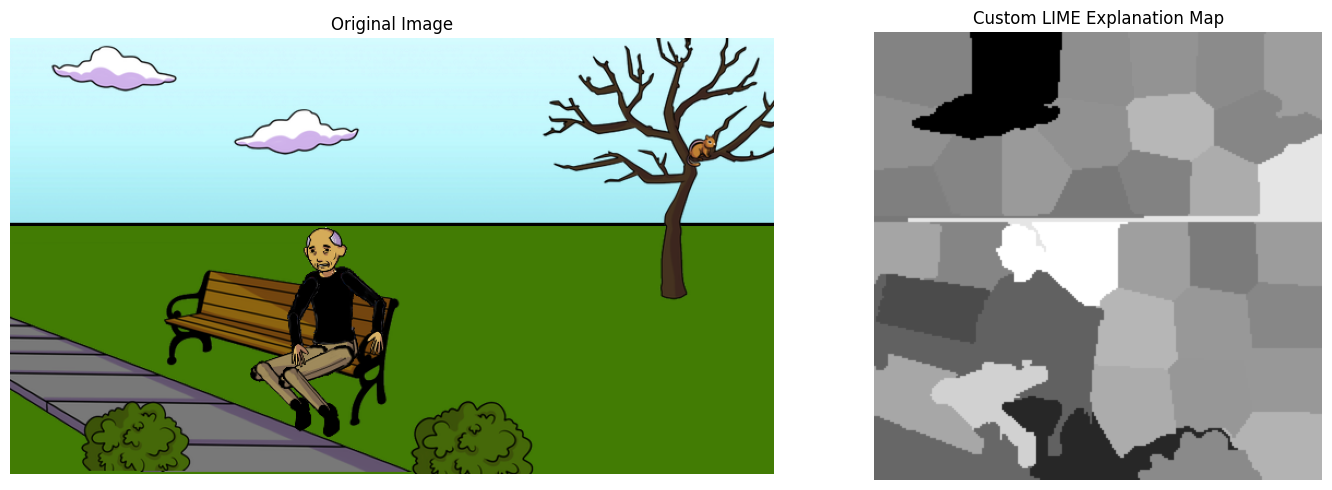

Generating LIME explanations for Example 2:
LIME Ranks for Example 2: [30. 21. 35. 25. 22. 12.  6. 19.  9.  7. 13. 24.  3. 20. 33. 34.  1.  4.
  8. 31. 18. 32. 17. 29. 10. 16. 28. 15. 26. 23. 27.  2. 36. 14.  5. 11.]



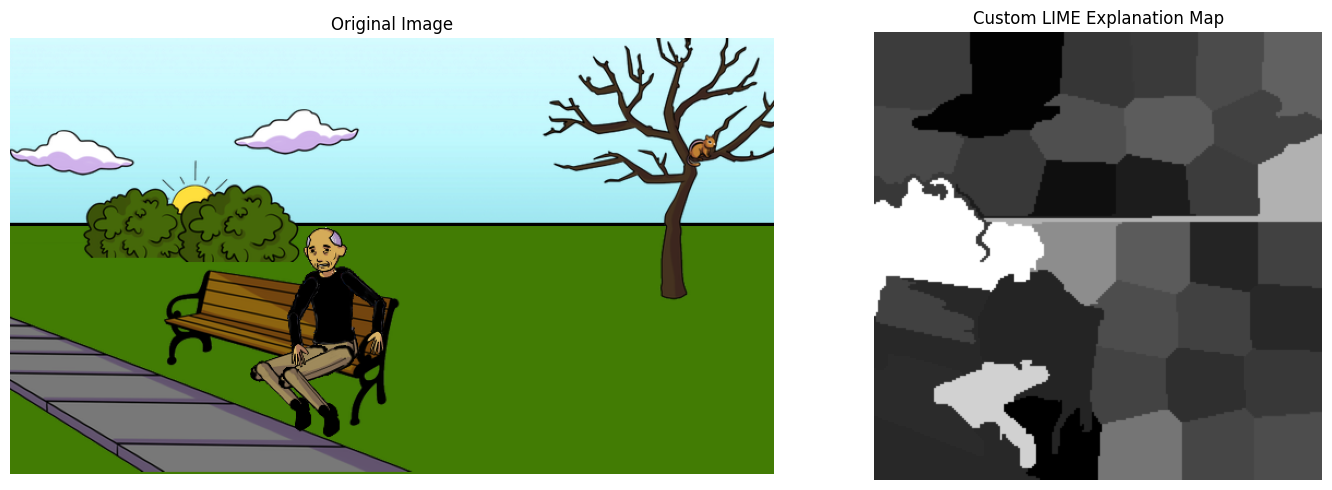

Generating LIME explanations for Example 3:
LIME Ranks for Example 3: [30.  2. 37. 38. 10. 14.  5. 26. 23.  6. 34. 12.  8. 35. 29. 31. 28. 19.
  1. 17. 27. 18. 15.  9.  4. 36. 21. 39. 11. 25. 20. 13. 32.  3.  7. 24.
 16. 33. 22.]



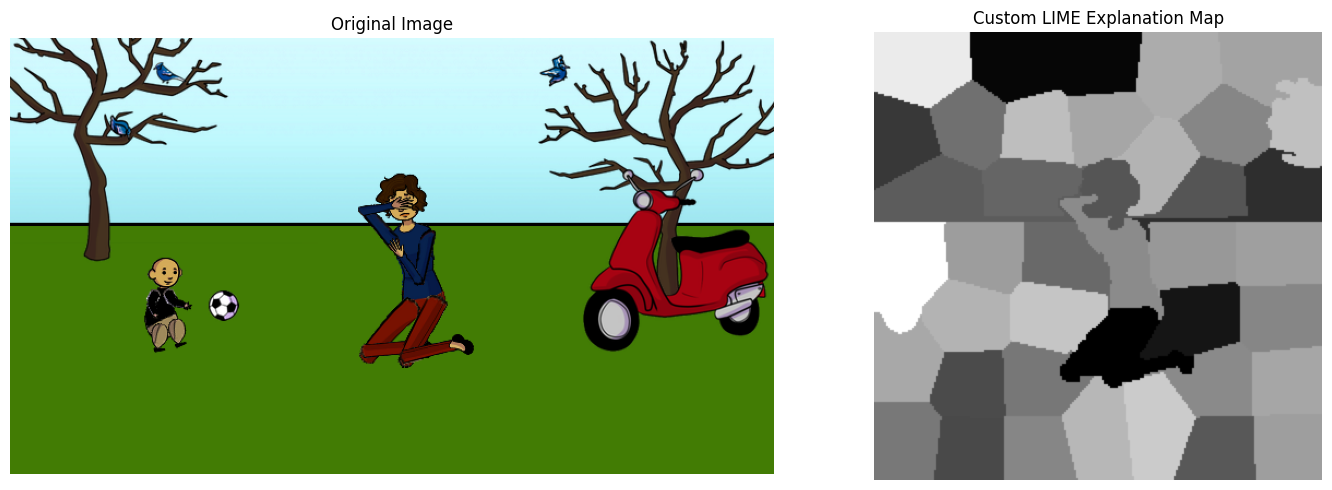

Generating LIME explanations for Example 4:
LIME Ranks for Example 4: [19.  8.  5. 16. 26. 30. 28. 34. 11. 20.  3. 18. 23. 33. 15. 29.  7. 25.
 13. 21. 27.  9.  1. 14. 10. 32. 22.  2.  4. 24.  6. 12. 31. 17.]



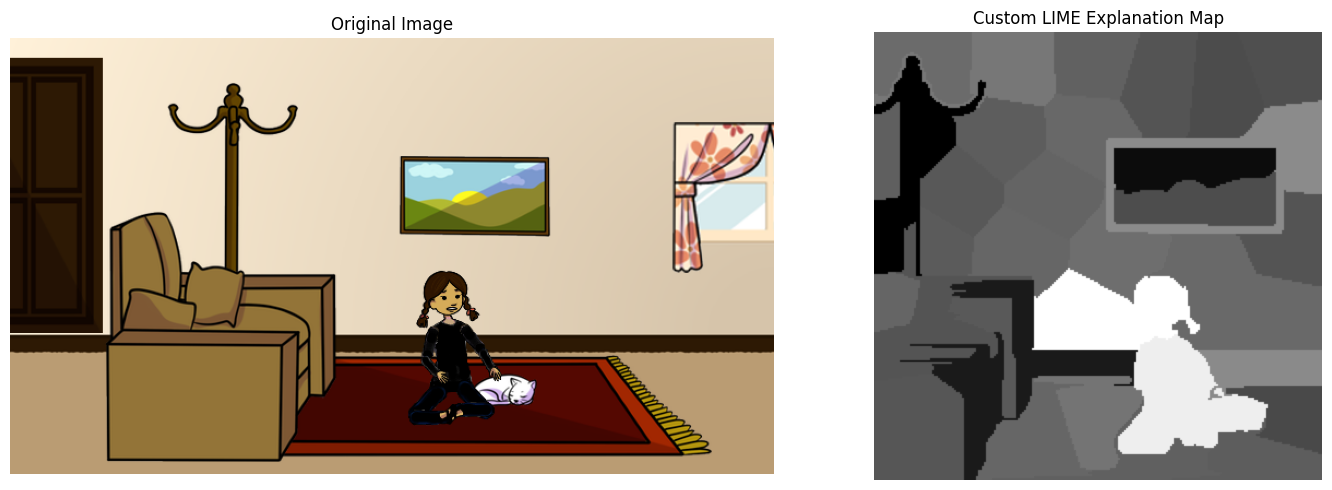

In [ ]:
for idx, (question_vec, pred, label, img_path) in enumerate(selected_examples):
    print(f"Generating LIME explanations for Example {idx+1}:")

    question = decode_question(question_vec, vocab)
    original_image = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(original_image).to(device)
    question_tokens = torch.tensor(question_vec, dtype=torch.long).unsqueeze(0).to(device)
    lengths = [len(question_vec)]
    segments = segment_image(img_tensor, n_segments=50)
    n_superpixels = np.unique(segments).shape[0]

    lime_map = custom_lime_explanation(
        img_tensor=img_tensor,
        question_tensor=question_tokens,
        lengths=lengths,
        model=model,
        target_class=pred,
        device=device,
        num_samples=500,
        n_segments=50,
        kernel_width=0.25
    )

    superpixel_lime = aggregate_lime_over_superpixels(lime_map, segments, n_superpixels)
    ranks_lime = get_ranks(superpixel_lime)

    print(f"LIME Ranks for Example {idx+1}: {ranks_lime}\n")

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    show_image(original_image, title='Original Image')
    plt.subplot(1, 2, 2)
    lime_explanation = lime_map
    lime_explanation = (lime_explanation - lime_explanation.min()) / (lime_explanation.max() - lime_explanation.min())
    show_grayscale_image(lime_explanation, title='Custom LIME Explanation Map')
    plt.tight_layout()
    plt.show()

Generating LIME explanations for Example 1:
Text Feature Importance:
Word: is, Importance: 0.0364
Word: it, Importance: 0.0182
Word: daylight, Importance: 0.0722
Word: ?, Importance: 0.0642
Word: <, Importance: 0.1697
Word: pad, Importance: 1.0000
Word: >, Importance: 0.1764


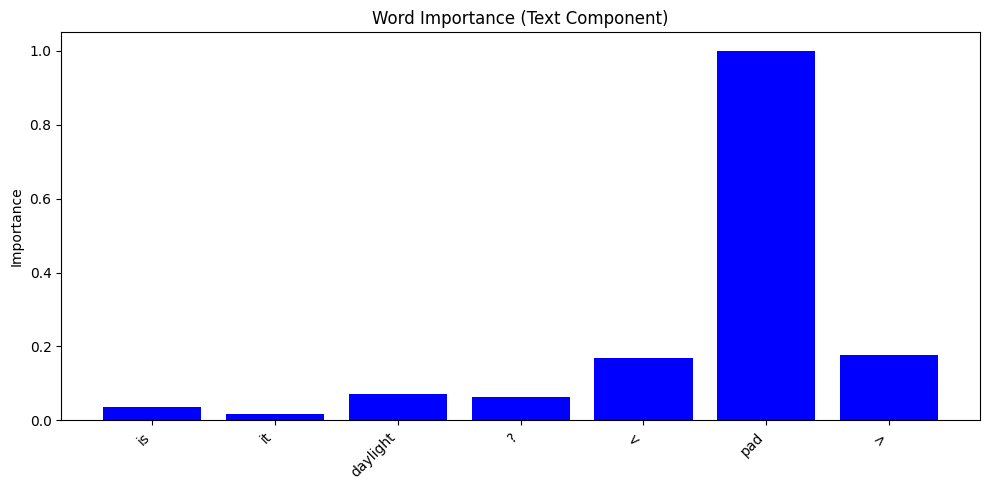

Generating LIME explanations for Example 2:
Text Feature Importance:
Word: is, Importance: 0.0218
Word: it, Importance: 0.0748
Word: daylight, Importance: 0.0461
Word: ?, Importance: 0.0245
Word: <, Importance: 0.1761
Word: pad, Importance: 1.0000
Word: >, Importance: 0.3458


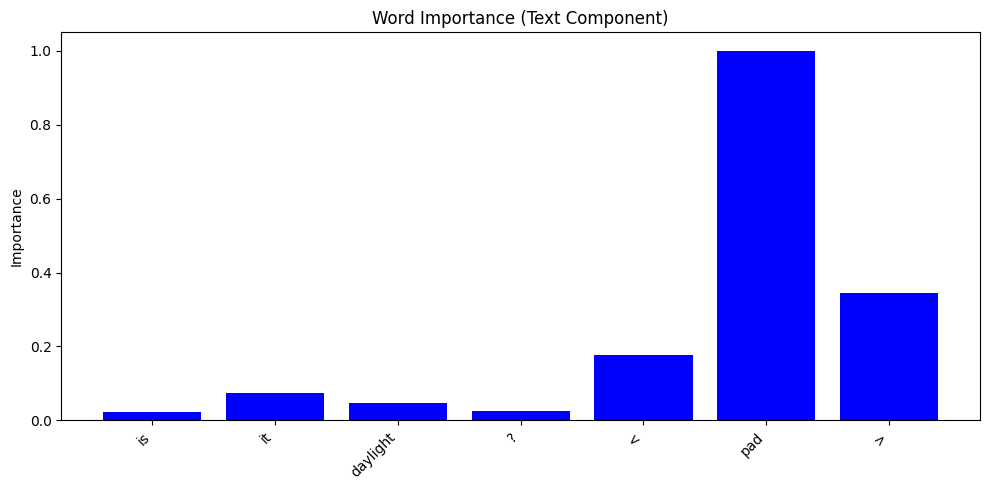

Generating LIME explanations for Example 3:
Text Feature Importance:
Word: is, Importance: 0.0853
Word: the, Importance: 0.0326
Word: woman, Importance: 0.0730
Word: crying, Importance: 0.1037
Word: ?, Importance: 0.0589
Word: <, Importance: 0.1361
Word: pad, Importance: 1.0000
Word: >, Importance: 0.3686


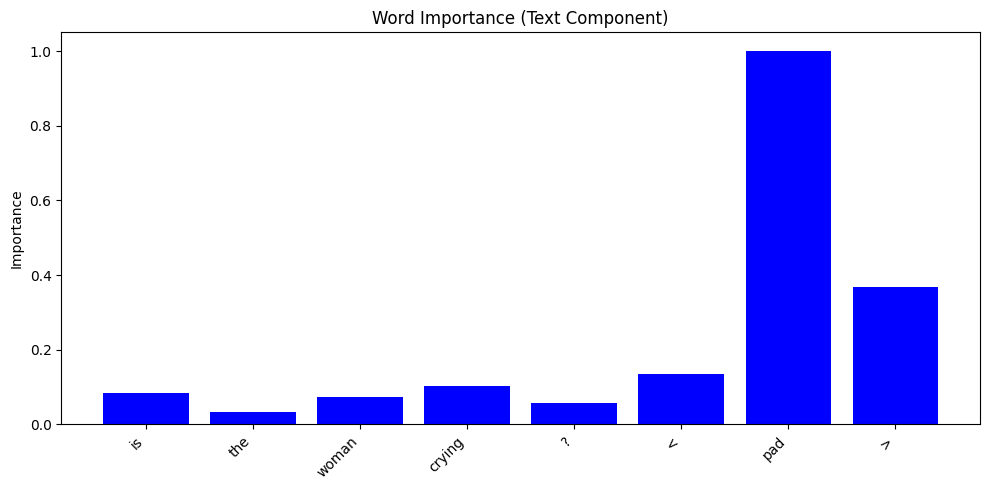

Generating LIME explanations for Example 4:
Text Feature Importance:
Word: is, Importance: 0.9260
Word: the, Importance: 0.9458
Word: girl, Importance: 0.9555
Word: trying, Importance: 0.9327
Word: to, Importance: 0.9676
Word: <, Importance: 0.8241
Word: unk, Importance: 0.9285
Word: >, Importance: 0.4065
Word: cat, Importance: 0.9850
Word: ?, Importance: 0.9669
Word: pad, Importance: 0.0000


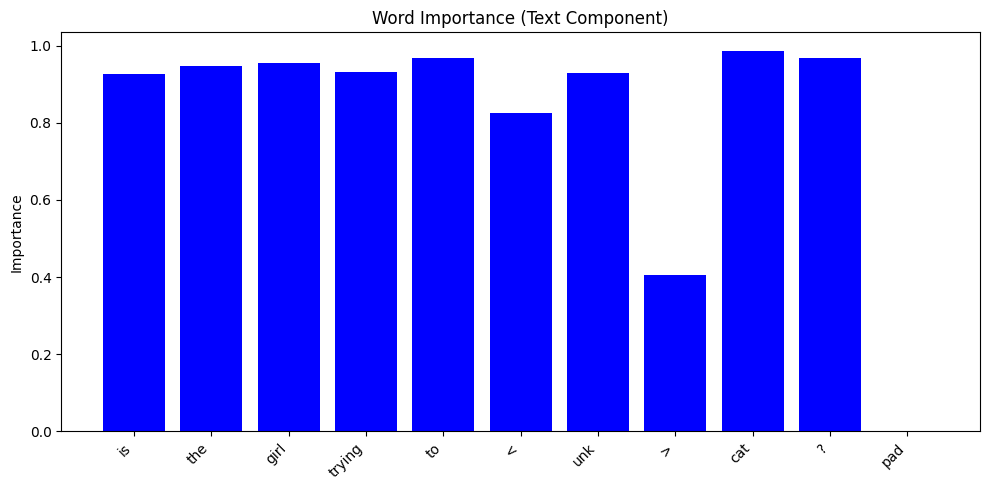

In [ ]:
def custom_lime_text_explanation(question_tensor, lengths, img_tensor, model, target_class, vocab, device, num_samples=500, kernel_width=0.25):
    question = decode_question(question_tensor.squeeze().cpu().numpy(), vocab)
    tokens = nltk.word_tokenize(question)
    n_words = len(tokens)

    perturbations = np.random.randint(0, 2, (num_samples, n_words))
    perturbations[0, :] = 1

    predictions = []
    for mask in perturbations:
        perturbed_tokens = [token if mask[i] == 1 else '<mask>' for i, token in enumerate(tokens)]
        perturbed_question = ' '.join(perturbed_tokens)
        perturbed_question_vec = [vocab.get(word, vocab['<unk>']) for word in nltk.word_tokenize(perturbed_question)]
        perturbed_question_tensor = torch.tensor(perturbed_question_vec, dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0).to(device), perturbed_question_tensor, [len(perturbed_question_vec)])
            prob = torch.softmax(output, dim=1)[0, target_class].item()
        predictions.append(prob)

    distances = pairwise_distances(perturbations, perturbations[0:1], metric="hamming").squeeze()
    weights = np.exp(-(distances**2) / kernel_width**2)
    clf = Ridge(alpha=1)
    clf.fit(perturbations, predictions, sample_weight=weights)
    word_importance = clf.coef_
    word_importance = (word_importance - word_importance.min()) / (word_importance.max() - word_importance.min())
    word_importance_dict = {tokens[i]: word_importance[i] for i in range(len(tokens))}
    return word_importance_dict

for idx, (question_vec, pred, label, img_path) in enumerate(selected_examples):
    print(f"Generating LIME explanations for Example {idx+1}:")

    question = decode_question(question_vec, vocab)
    original_image = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(original_image).to(device)
    question_tensor = torch.tensor(question_vec, dtype=torch.long).unsqueeze(0).to(device)
    lengths = [len(question_vec)]

    text_importance = custom_lime_text_explanation(
        question_tensor=question_tensor,
        lengths=lengths,
        img_tensor=img_tensor,
        model=model,
        target_class=pred,
        vocab=vocab,
        device=device,
        num_samples=500,
        kernel_width=0.25
    )

    print("Text Feature Importance:")
    for word, importance in text_importance.items():
        print(f"Word: {word}, Importance: {importance:.4f}")

    plt.figure(figsize=(10, 5))
    plt.bar(text_importance.keys(), text_importance.values(), color='blue')
    plt.xticks(rotation=45, ha='right')
    plt.title("Word Importance (Text Component)")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()


Generating combined LIME explanations for Example 1:


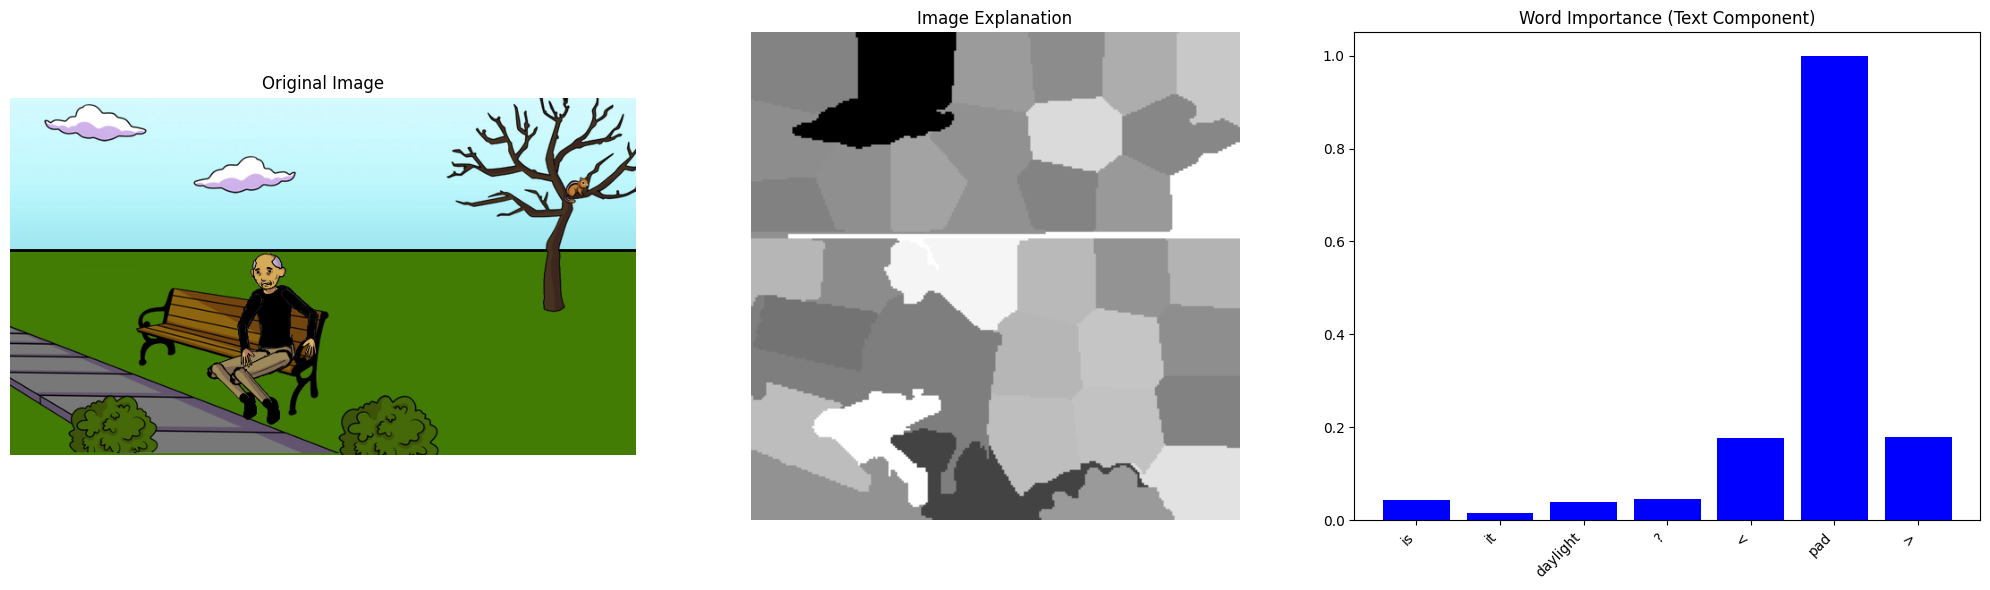

Generating combined LIME explanations for Example 2:


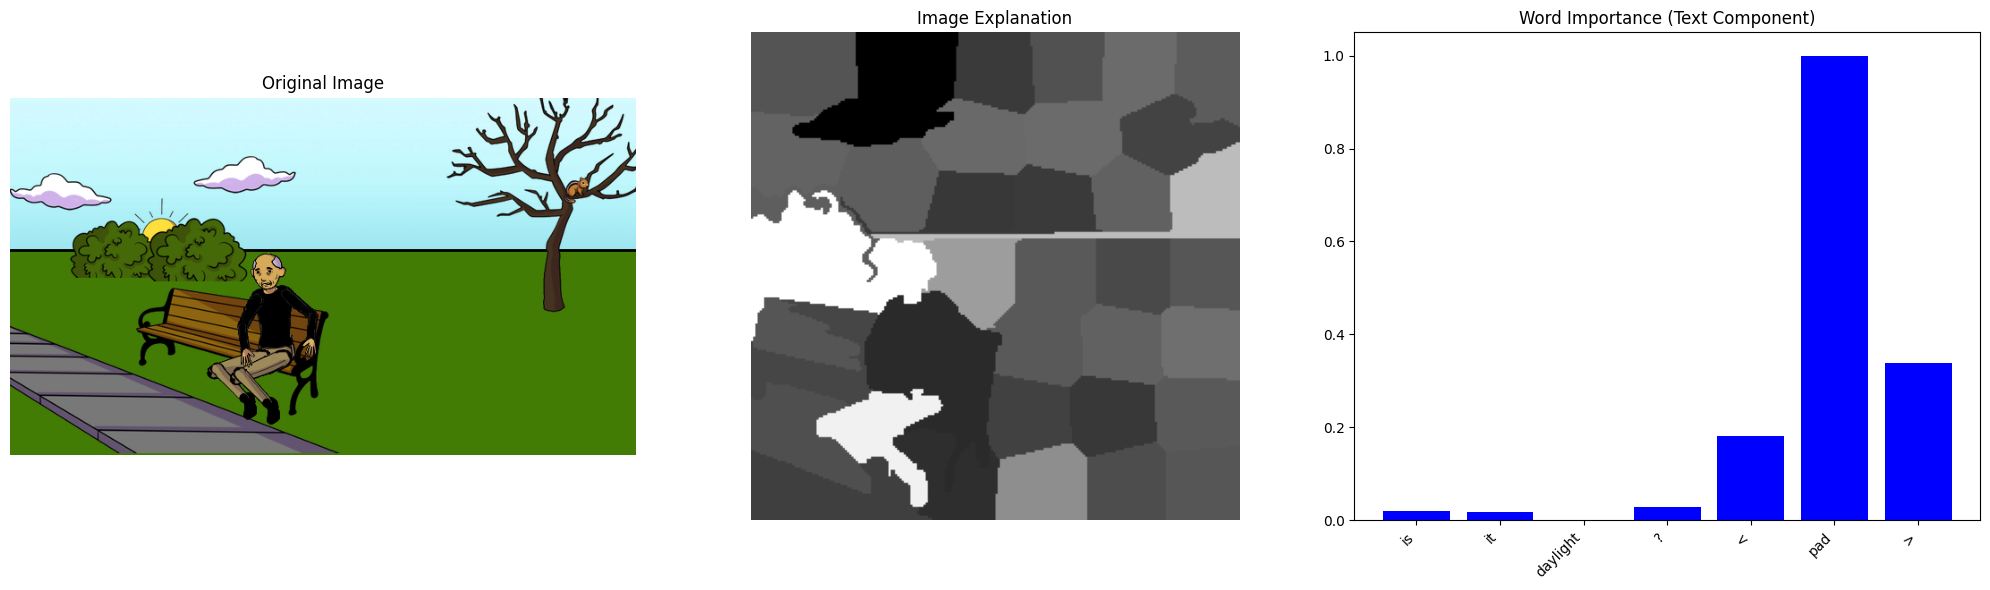

Generating combined LIME explanations for Example 3:


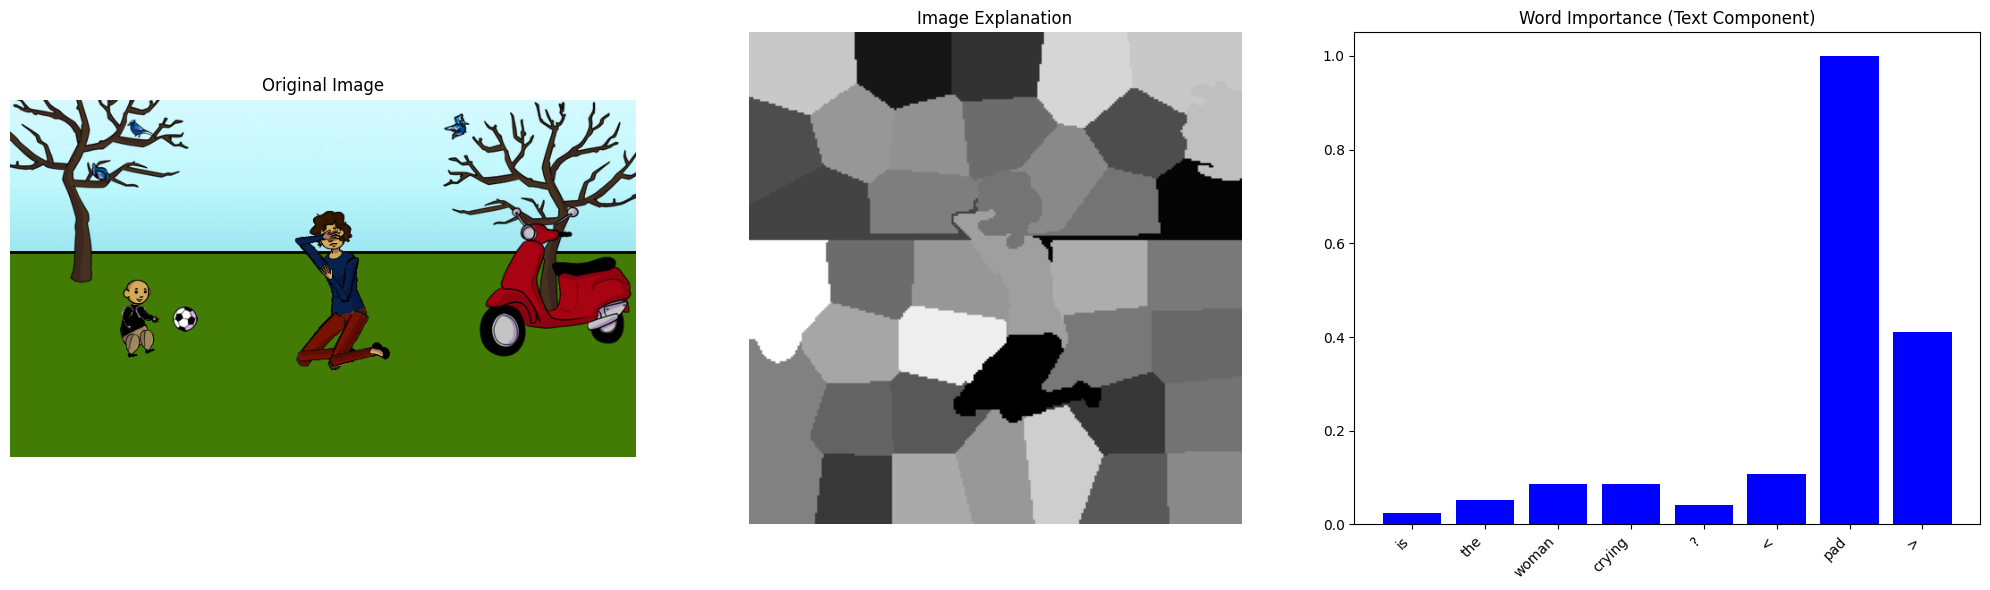

Generating combined LIME explanations for Example 4:


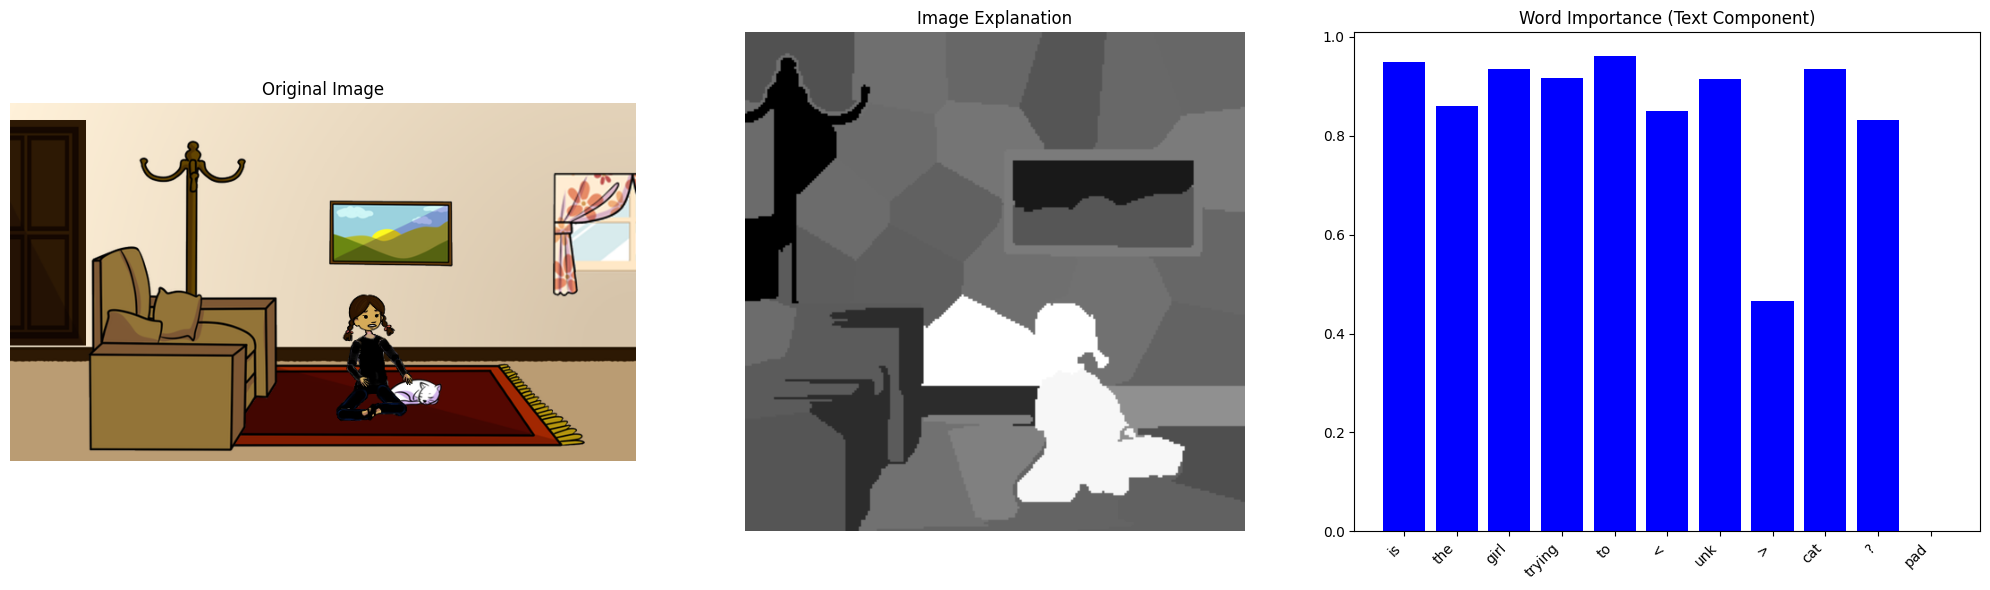

In [ ]:
for idx, (question_vec, pred, label, img_path) in enumerate(selected_examples):
    print(f"Generating combined LIME explanations for Example {idx+1}:")

    question = decode_question(question_vec, vocab)
    original_image = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(original_image).to(device)
    question_tensor = torch.tensor(question_vec, dtype=torch.long).unsqueeze(0).to(device)
    lengths = [len(question_vec)]

    text_importance = custom_lime_text_explanation(
        question_tensor=question_tensor,
        lengths=lengths,
        img_tensor=img_tensor,
        model=model,
        target_class=pred,
        vocab=vocab,
        device=device
    )
    image_segments = segment_image(img_tensor, n_segments=50)
    image_importance = custom_lime_explanation(
        img_tensor=img_tensor,
        question_tensor=question_tensor,
        lengths=lengths,
        model=model,
        target_class=pred,
        device=device
    )

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    show_image(original_image, title='Original Image')
    plt.subplot(1, 3, 2)
    lime_explanation = image_importance
    lime_explanation = (lime_explanation - lime_explanation.min()) / (lime_explanation.max() - lime_explanation.min())
    show_grayscale_image(lime_explanation, title='Image Explanation')
    plt.subplot(1, 3, 3)
    plt.bar(text_importance.keys(), text_importance.values(), color='blue')
    plt.xticks(rotation=45, ha='right')
    plt.title("Word Importance (Text Component)")
    plt.tight_layout()
    plt.show()